In [1]:
import cantata
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from box import Box
from cantata.plotting import output as cp
from cantata import cfg

In [2]:
figsize = (14,5)

In [3]:
print(cfg.model_config)

1tier.yaml


In [4]:
# Extract populations & projections:
populations = Box()
drivers = Box()
projections = Box()
for name, pop in cfg.model.populations.items():
    p = pop.copy()
    projections[name] = p.targets
    del p.targets
    if p.rate >= 0:
        drivers[name] = p
    else:
        populations[name] = p

In [5]:
for name in drivers.keys():
    assert np.all([name not in t for t in projections.values()]), name

In [6]:
base_cfg = cfg.copy()
del base_cfg.model_config
base_cfg.model.populations = Box()

In [7]:
second = int(1/base_cfg.time_step)

tau in [0.783, 114.655] ms
mean: 20.0 +- 11.6 ms


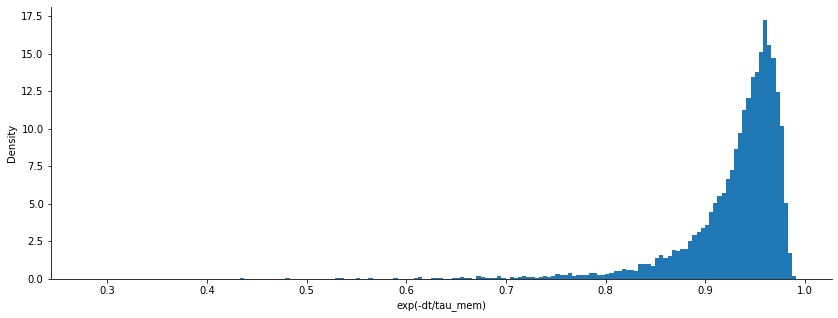

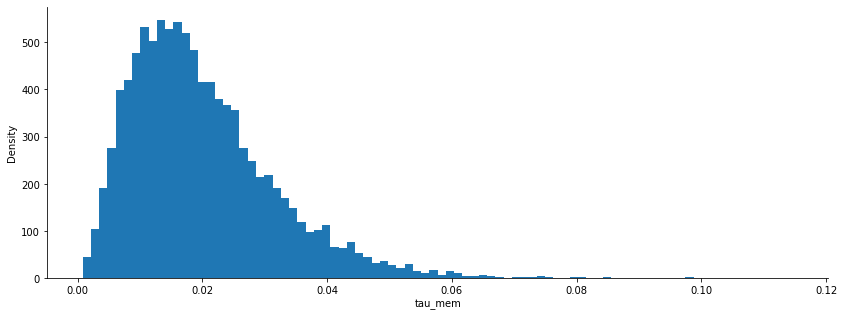

In [16]:
# Membrane time constant check
tau_cfg = base_cfg.copy()
tau_cfg.batch_size = 1
tau_cfg.n_inputs = 0
tau_cfg.model.populations.Probe = {'n': 10000}
cantata.config.load(tau_cfg)
m = cantata.Module()
plt.figure(figsize=figsize)
plt.hist(m.alpha_mem.cpu().numpy(), density=True, histtype='stepfilled', bins='auto')
plt.xlabel('exp(-dt/tau_mem)')
plt.ylabel('Density')
sns.despine()

plt.figure(figsize=figsize)
tau = -cfg.time_step / torch.log(m.alpha_mem).cpu().numpy()
plt.hist(tau, histtype='stepfilled', bins='auto')
plt.xlabel('tau_mem')
plt.ylabel('Density')
sns.despine()
print(f'tau in [{min(tau)/tau_cfg.time_step:.3f}, {max(tau)/tau_cfg.time_step:.3f}] ms')
print(f'mean: {np.mean(tau)/tau_cfg.time_step:.1f} +- {np.std(tau)/tau_cfg.time_step:.1f} ms')

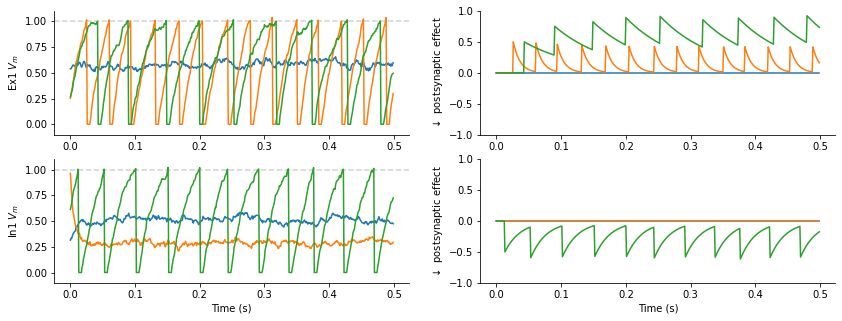

In [40]:
# Activity check
n = 3
act_cfg = base_cfg.copy()
act_cfg.batch_size = 1
act_cfg.n_inputs = 0
act_cfg.n_steps = int(0.5*second)
act_cfg.model.populations.Output = Box({'n': n})

inputs = torch.zeros(act_cfg.batch_size, act_cfg.n_steps, act_cfg.n_inputs, **act_cfg.tspec)
t = np.arange(act_cfg.n_steps) * act_cfg.time_step

plt.figure(figsize=figsize)
for i, (name, pop) in enumerate(populations.items()):
    act_cfg.model.populations.Probe = pop.copy()
    act_cfg.model.populations.Probe.n = n
    act_cfg.model.populations.Probe.targets = Box(dict(Output={}))
    cantata.config.load(act_cfg)
    m = cantata.Module()
    with torch.no_grad():
        state,epoch,record = m.forward_init(inputs, ['mem'])
        epoch.W[n:,:n] = torch.eye(n,n, device=epoch.W.device) * 0.5 * torch.sign(epoch.W[n:,0]) # Probe to Output
        state.mem[0,:n] = 0
        m.forward_run(state,epoch,record)
        m.forward_close(record)
    
    plt.subplot(2,len(populations),2*i+1)
    plt.axhline(1, c='lightgray', ls='--')
    for j in range(n):
        plt.plot(t, record.mem[0,:,j+n].cpu().numpy())
    plt.ylabel(f'{name} $V_m$')
    plt.ylim([-.1,1.1])
    if i==len(populations)-1:
        plt.xlabel('Time (s)')
    
    plt.subplot(2,len(populations),2*i+2)
    for j in range(n):
        plt.plot(t, record.mem[0,:,j].cpu().numpy())
    plt.ylabel('$\downarrow$ postsynaptic effect')
    plt.ylim([-1,1])
    if i==len(populations)-1:
        plt.xlabel('Time (s)')
sns.despine()

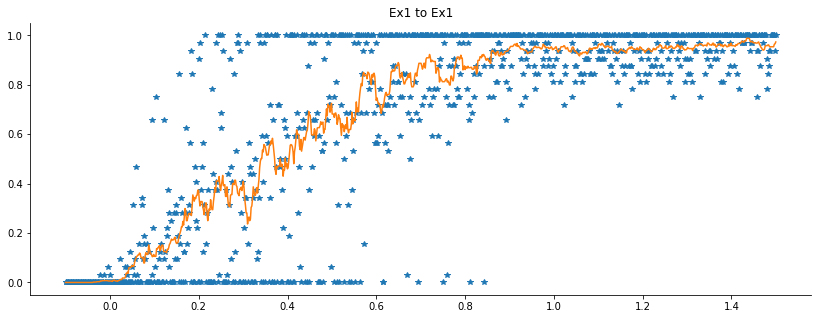

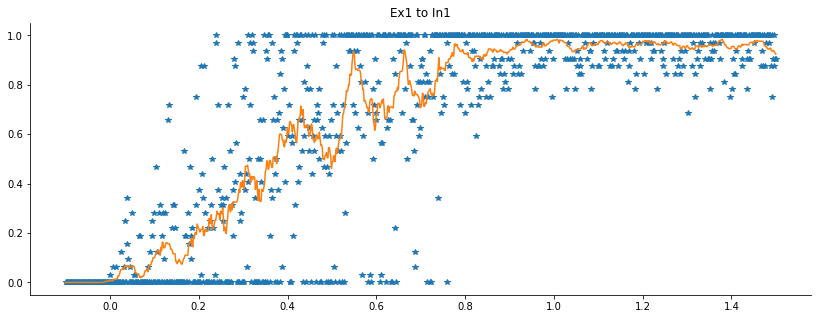

In [65]:
# Firing probability check
delay = 0.05
n = 1000
weight = torch.linspace(-.1, 1.5, n)
window = torch.ones(21)/21
batch_size = 32

pf_cfg = base_cfg.copy()
pf_cfg.batch_size = batch_size
pf_cfg.n_inputs = 1
pf_cfg.n_steps = int(delay/pf_cfg.time_step) + 3
pf_cfg.model.populations.Driver = Box(dict(rate=0, targets=dict(Pre={})))
# pf_cfg.model.tau_ref = 0

inputs = torch.zeros(pf_cfg.batch_size, pf_cfg.n_steps, pf_cfg.n_inputs, **pf_cfg.tspec)
surefire = 1/pf_cfg.time_step
inputs[:, 0, :] = surefire

for i, (name, pop) in enumerate(populations.items()):
    if pop.sign < 0:
        continue
    for j, target_name in enumerate(projections[name].keys()):
        pf_cfg.model.populations.Pre = pop.copy()
        pf_cfg.model.populations.Pre.n = n
        pf_cfg.model.populations.Pre.targets = dict(Post={'delay':delay})
        pf_cfg.model.populations.Post = populations[target_name].copy()
        pf_cfg.model.populations.Post.n = n
#         pf_cfg.model.populations.Post.noise_N = 0
        cantata.config.load(pf_cfg)
        m = cantata.Module()
        with torch.no_grad():
            state,epoch,record = m.forward_init(inputs, ['mem'])
            epoch.W[0,1:1+n] = 1 # Driver to Pre
            epoch.W[1:1+n,1+n:] = torch.eye(n) * weight # Pre to Post
            m.forward_run(state,epoch,record)
            m.forward_close(record)

        plt.figure(figsize=figsize)
        plt.title(f'{name} to {target_name}')
        probability = record.out[:,-1,1+n:].sum(dim=0) / batch_size
        l = (len(window)-1)//2
        p_padded = torch.nn.functional.pad(probability, (l,l)) # mode=replicate for dim<3 NYI
        p_padded[:l] = probability[:l]
        p_padded[-l:] = probability[-l:]
        p_smooth = torch.nn.functional.conv1d(
            p_padded.view(1,1,-1),
            window.view(1,1,-1).to(probability.device)
        )
        plt.plot(weight.numpy(), probability.cpu().numpy(), '*')
        plt.plot(weight.numpy(), p_smooth[0,0].cpu().numpy(), '-')
        sns.despine()
        
#         nz = torch.nonzero(record.out[:,-1,-1] == 0)
#         if len(nz):
#             plt.figure()
#             plt.plot(record.mem[nz[0,0].item(),:,-1].cpu().numpy())

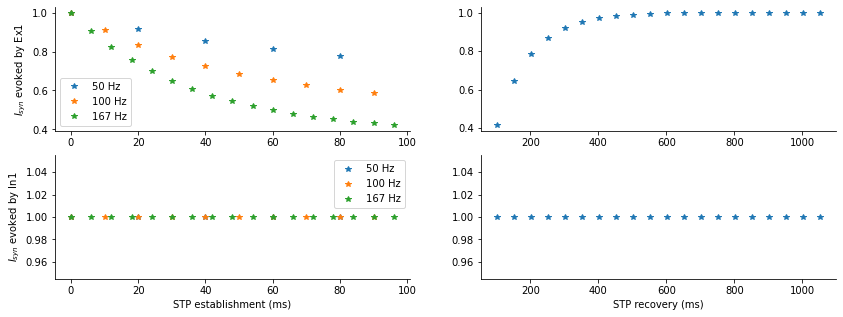

In [11]:
# STP sanity check
establish_end = 100

# To probe establishment - final value is used for recovery:
est_steps = [20,10,6] # Establishment ISIs, ms
est_ms = [torch.arange(establish_end/s) * s for s in est_steps]

# To probe recovery:
rec_steps = 20 # Number of recovery probes
recover_step = 50 # Spacing between recovery probes, ms
establish_step = est_steps[-1]
establish_ms = torch.arange(0,establish_end,establish_step)
recover_ms = torch.arange(rec_steps)*recover_step + establish_ms[-1] + est_steps[-1]

ms_to_idx = lambda ms: (ms/(1000*base_cfg.time_step)).to(torch.long)
establish_idx = ms_to_idx(establish_ms)
recover_idx = ms_to_idx(recover_ms)
est_idx = [ms_to_idx(est) for est in est_ms]

stp_cfg = base_cfg.copy()
stp_cfg.batch_size = rec_steps + len(est_steps)
stp_cfg.n_inputs = 1
stp_cfg.n_steps = recover_idx[-1] + 3
stp_cfg.model.populations.Driver = Box(dict(rate=0, targets=dict(Probe={})))
stp_cfg.model.populations.Output = Box({})

inputs = torch.zeros(stp_cfg.batch_size, stp_cfg.n_steps, stp_cfg.n_inputs, **stp_cfg.tspec)
surefire = 1/stp_cfg.time_step
inputs[:rec_steps, establish_idx, :] = surefire
inputs[torch.arange(rec_steps), recover_idx, :] = surefire

for i,idx in enumerate(est_idx):
    inputs[rec_steps + i, idx, :] = surefire

plt.figure(figsize=figsize)
for i, (name, pop) in enumerate(populations.items()):
    stp_cfg.model.populations.Probe = pop.copy()
    stp_cfg.model.populations.Probe.n = 1
    stp_cfg.model.populations.Probe.noise_N = 0
    stp_cfg.model.populations.Probe.targets = Box(dict(Output={}))
    cantata.config.load(stp_cfg)
    m = cantata.Module()
    with torch.no_grad():
        state,epoch,record = m.forward_init(inputs, ['syn'])
        epoch.W[0,2] = 1 # Driver to Probe
        epoch.W[2,1] = 1 # Probe to Output
        m.forward_run(state,epoch,record)
        m.forward_close(record)
    
    plt.subplot(2,len(populations),2*i+1)
    for j,idx in enumerate(est_idx):
        plt.plot(est_ms[j], record.syn[rec_steps+j, idx+2, 1].cpu().numpy(), '*',
                 label=f'{1/(cfg.time_step * est_steps[j]):.0f} Hz')
    plt.legend()
    if i==len(populations)-1:
        plt.xlabel('STP establishment (ms)')
    plt.ylabel(f'$I_{{syn}}$ evoked by {name}')
    
    plt.subplot(2,len(populations),2*i+2)
    plt.plot(recover_ms, record.syn[torch.arange(rec_steps),recover_idx+2,1].cpu().numpy(), '*')
    if i==len(populations)-1:
        plt.xlabel('STP recovery (ms)')
sns.despine()

In [13]:
# STDP check: Engineered pairs
def stdp_plot(source_name, target_name,
              n_probes = 51, probe_spacing = 0.002,
              burst = 1, burst_spacing = 0.005,
              v_post = 0.5, with_noise = False, batch_size = 32,
              plot_traces = True,
              kd = 1, kp = 1):
    stdp_cfg = base_cfg.copy()
    stdp_cfg.batch_size = batch_size
    stdp_cfg.n_inputs = 3
    stdp_cfg.n_steps = int(n_probes * probe_spacing / stdp_cfg.time_step) + 10
    stdp_cfg.model.populations.Driver_pre = Box(dict(rate=0, targets={}))
    stdp_cfg.model.populations.Driver_post = Box(dict(rate=1, targets={'Post':{}}))
    stdp_cfg.model.populations.Driver_vpost = Box(dict(rate=2, targets={'Post':{}}))
    stdp_cfg.model.tau_mem_gamma = 0
    for i in range(n_probes):
        stdp_cfg.model.populations.Driver_pre.targets[f'Pre_{i}'] = {'delay': probe_spacing*i}
    stdp_cfg.model.stdp_wmax_total = 2
    stdp_cfg.model.tau_ref = 0

    inputs = torch.zeros(stdp_cfg.batch_size, stdp_cfg.n_steps, stdp_cfg.n_inputs, **stdp_cfg.tspec)
    surefire = 1/stdp_cfg.time_step
    inputs[:,0,0] = surefire
    burst_idx = torch.ones(burst)*(1 + int(n_probes//2 * probe_spacing/stdp_cfg.time_step)) + \
        torch.arange(0,-burst,-1) * burst_spacing/stdp_cfg.time_step
    inputs[:,burst_idx.to(torch.long),1] = surefire
    if not with_noise:
        inputs[:,:,2] = surefire

    t = np.arange(stdp_cfg.n_steps) * .001/stdp_cfg.time_step
    dt = (np.arange(n_probes) - n_probes//2) * probe_spacing * 1000

    for i in range(n_probes):
        proj = projections[source_name][target_name].copy()
        proj.delay = 0
        proj.density = 1
        proj.A_p *= kp
        proj.A_d *= kd
        source = (populations[source_name] if source_name in populations else drivers[source_name]).copy()
        source.n = 1
        source.targets = {f'Post': proj}
        if not with_noise:
            source.noise_N = 0
        stdp_cfg.model.populations[f'Pre_{i}'] = source
    target = populations[target_name].copy()
    target.n = n_probes
    if not with_noise:
        target.noise_N = 0
    stdp_cfg.model.populations.Post = target

    cantata.config.load(stdp_cfg)
    m = cantata.Module()
    with torch.no_grad():
        state,epoch,record = m.forward_init(inputs, ['w_stdp', 'mem'])
        state.mem[:] = 0
        epoch.W[0][epoch.W[0]>0] = 1
        epoch.W[1][epoch.W[1]>0] = 1 + (-v_post if v_post < 0 else 0)
        epoch.W[2] = torch.where(epoch.W[2]>0, v_post - v_post*m.alpha_mem, torch.zeros_like(m.alpha_mem))
        state.mem[:,3+n_probes:] = v_post
        state.u_dep[:,3+n_probes:] = v_post
        state.u_pot[:,3+n_probes:] = v_post
        state.th_dep[:,3+n_probes:] = v_post
        epoch.W[3:3+n_probes, 3+n_probes:] = torch.eye(n_probes)*(1-v_post)/2*source.sign
        m.forward_run(state,epoch,record)
        m.forward_close(record)

    if plot_traces:
        plt.figure(figsize=figsize)
        for i,k in enumerate(range(n_probes)):
            plt.subplot(n_probes,2,2*i+1)
            plt.plot(record.mem[0,:,3 + k].cpu().numpy(), label='pre')
            plt.plot(record.mem[0,:,3 + n_probes + k].cpu().numpy(), label='post')
            if i < n_probes-1:
                plt.axis('off')
            else:
                sns.despine()
                plt.xlabel('Time (ms)')

            ax = plt.subplot(n_probes,2,2*i+2)
            plt.plot(record.w_stdp[0,:, 3+k, 3+n_probes+k].cpu().numpy())
            if i < n_probes-1:
                plt.axis('off')
            else:
                ax.get_yaxis().set_visible(False)
                sns.despine(left=True)
                plt.xlabel('Time (ms)')

    plt.figure(figsize=figsize)
    plt.axhline(0, c='lightgray', ls='--')
    first_half = np.ones(n_probes//2 + 1) * (2 + int(n_probes//2 * probe_spacing/stdp_cfg.time_step)) + 1
    second_half = np.arange(1, n_probes//2+1) * probe_spacing/stdp_cfg.time_step + first_half[0]-1
    idx_after = torch.tensor(np.concatenate((first_half, second_half)),dtype=torch.long)
    dw = record.w_stdp[:, idx_after, range(3,3+n_probes), range(3+n_probes,3+2*n_probes)] - \
         record.w_stdp[:, idx_after-1, range(3,3+n_probes), range(3+n_probes,3+2*n_probes)]
    dw_0 = np.flip(dw[0].cpu().numpy())
    plt.plot(dt, dw_0, 'g*-')
    plt.xlabel('t_post - t_pre (ms)')
    plt.ylabel('Relative weight change')
    
    if with_noise:
        dw_mean = np.flip(dw.mean(dim=0).cpu().numpy())
        plt.plot(dt, dw_mean, 'ro-')
        return dw_0, dw_mean
    else:
        return dw_0

In [14]:
def stdp_check_all(**kwargs):
    for source_name, targets in projections.items():
        for target_name, projection in targets.items():
            if projection.A_p > 0 or projection.A_d > 0:
                stdp_plot(source_name, target_name, **kwargs)

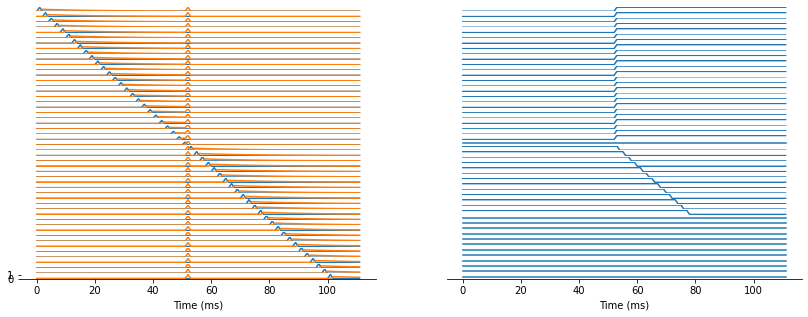

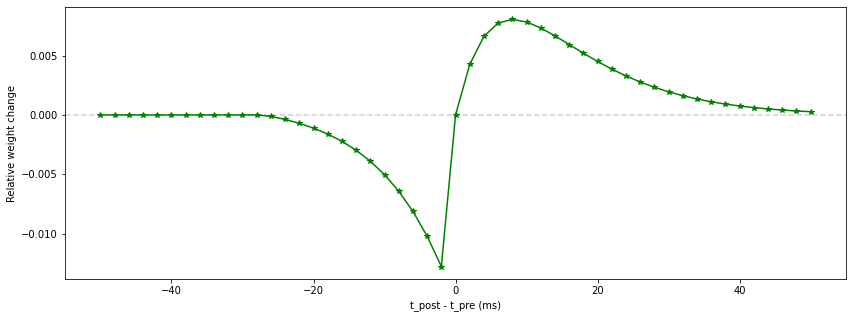

In [81]:
stdp_check_all(v_post=0.0)

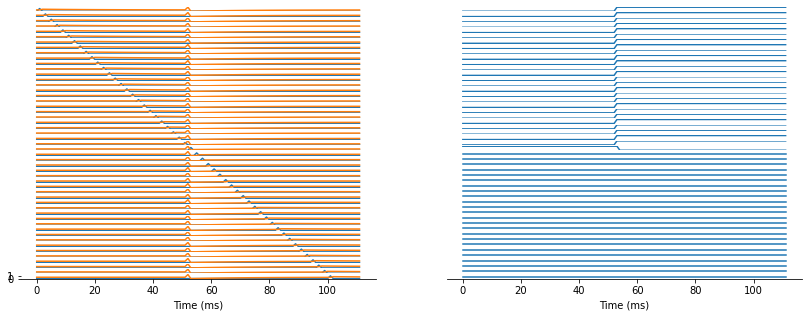

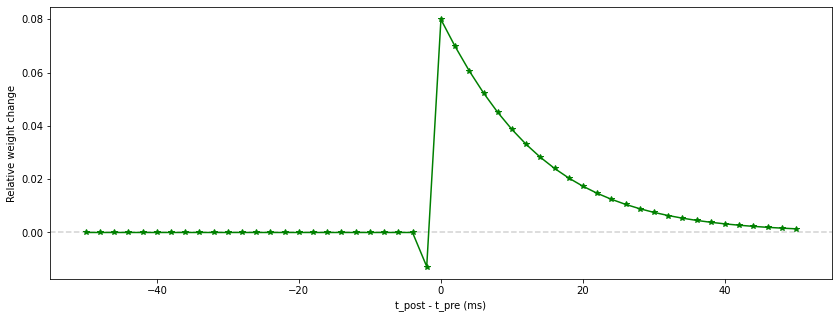

In [82]:
stdp_check_all(v_post = 0.5)

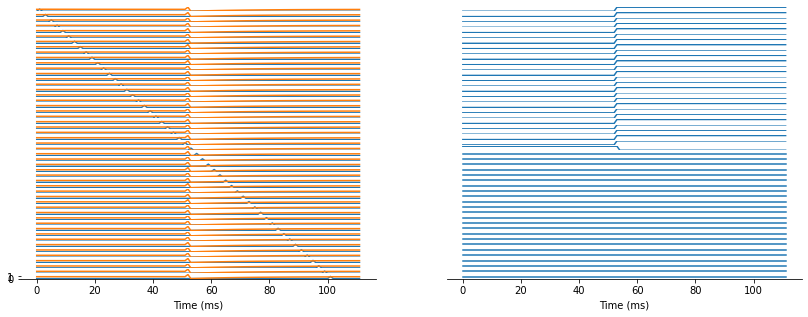

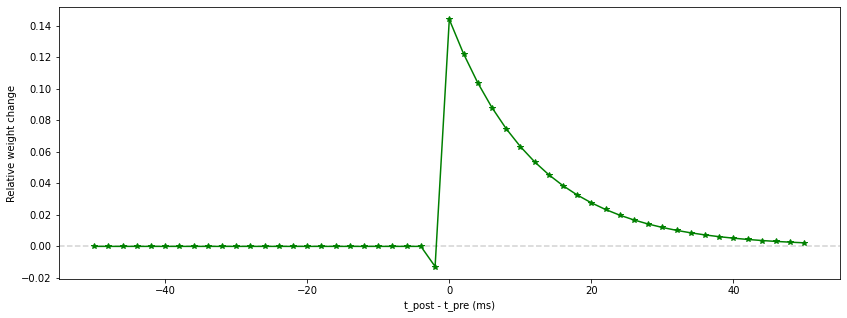

In [83]:
stdp_check_all(v_post = 0.9)

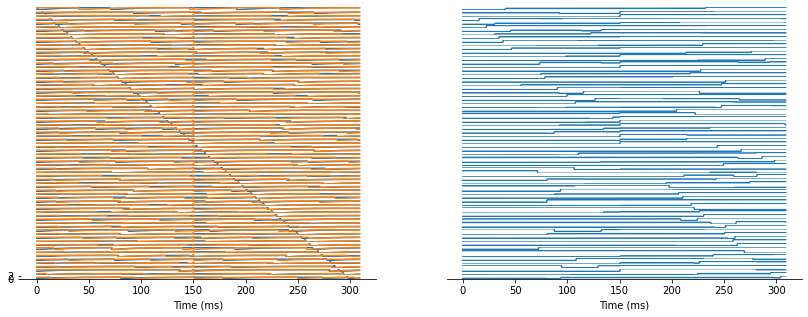

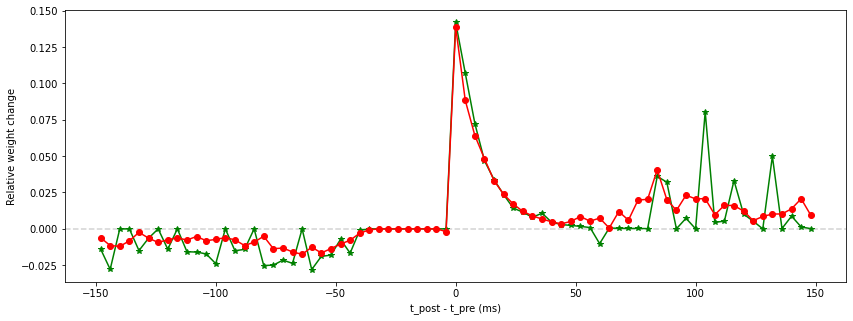

In [17]:
stdp_check_all(v_post = 0.9, with_noise = True, n_probes=75, probe_spacing = .004)

Reflections on the **depression** side (left/bottom half, spike order post -> pre, weight change measured at t_pre):
- *Very short interval*: u_dep is drawn above threshold by the stimulation.
- *Intermediate intervals* (~4-40 ms): u_dep is drawn below threshold by the refractory period, and takes some time to recover towards the slower-moving threshold.
- *Longer intervals* (>40 ms): On average, u_dep has recovered to the threshold, and now lies above threshold ~50% of the time, as long as the neuron does not spike spontaneously. The dip between 40 and 80 ms appears to be a reflection of the slight drop in the threshold and is abolished when triggered postsynaptic spikes are removed.

Conversely, on the **potentiation** side (right/top half, spike order pre -> post, weight change measured at t_post):
- Short and intermediate intervals: Potentiation is dominated by the filtered presynaptic trace x_bar, which decays with a time constant of 12 ms.
- Longer intervals (>50ms): In the presynaptic neuron, the hyperpolarising effect of the triggered spike (refractory & reset to rest) has worn off, allowing spontaneous spikes to occur in the meantime.